In [6]:
def rmse(n,exa,num):
    e = 0.
    for i in range(n):
        e += (exa[i]-num[i])**2
    e = math.sqrt(e/n)
    return e

def contour_plot(nx,ny,x,sol,exa,unod):
    X = np.zeros(nx)
    Y = np.zeros(ny)
    Z_sol = np.zeros((ny,nx))
    Z_exa = np.zeros((ny,nx))
    for i in range(nx):
        X[i] = x[i][0]
    for i in range(ny):
        Y[i] = x[nx*i][1]
    c = 0
    for i in range(ny):
        for j in range(nx):
            Z_sol[i][j] = sol[c]
            Z_exa[i][j] = exa[c]
            c += 1
            
    #plt.contour(X, Y, Z_sol, 20, colors='black')
    #plt.contour(X, Y, Z_exa, 20, colors='red')
    #plt.quiver(X,Y,unod[:,0],unod[:,1], color='b', units='xy', scale=1)
    #plt.show()
    #plt.legend(['numerical reults','exact function'])
    #plt.legend(['potential','|u|'])
    
def plotMesh(elements, nodes,l2g=False):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(9,9)); plt.rcParams.update({'font.size': 22})
    for eN, e in enumerate(elements):
        element_nodes = nodes[e[0]], nodes[e[1]], nodes[e[2]]
        X = [n[0] for n in element_nodes]; Y = [n[1] for n in element_nodes]
        cx = sum(X)/3.; cy = sum(Y)/3.
        X.append(element_nodes[0][0]); Y.append(element_nodes[0][1])
        plt.plot(X, Y); plt.text(cx, cy, "$T_{{{0:d}}}$".format(eN))
        for n in e:  
            plt.text(nodes[n,0], nodes[n,1], "$N_{{{0:d}}}$".format(n))
    if l2g:
        plt.text(nodes[n,0], nodes[n,1], "$N_{{ {0:d} = elements[{1:d},{2:d}] = elements[0,1]}}$".format(n,eN,2))
    plt.axis('equal')
    return plt

def mesh(L,h,he):
    # element number and size
    nex = int(math.ceil(L/he))
    ney = int(math.ceil(h/he))
    ne = 2*nex*ney
    dx = L/nex
    dy = h/ney
    
    # node number
    nx = nex+1
    ny = ney+1
    n = nx*ny
    
    # mesh
    c = 0
    x = np.zeros((n,2))
    for j in range(ny):
        for i in range(nx):
            x[c][0] = dx*i
            x[c][1] = dy*j
            c += 1
            
    # local-global index for triangle mesh
    c = 0
    ln = np.zeros((ne,3), dtype=int)
    for j in range(ney):
        for i in range(nex):
            ln[2*c][0] = nx*j+i    # lower tri.
            ln[2*c][1] = nx*j+i+1
            ln[2*c][2] = nx*(j+1)+i
            ln[2*c+1][0] = nx*j+i+1     # upper tri.
            ln[2*c+1][1] = nx*(j+1)+1+i
            ln[2*c+1][2] = nx*(j+1)+i          
            c += 1
            
    # who is the node with BC
    idir = []
    ineu = []
    for i in range(n):
        if x[i][1] == h:   # free surface
            idir.append(i)
        elif x[i][0] == 0: # left wall
            ineu.append(i)
        elif x[i][0] == L: # right wall
            ineu.append(i)
        elif x[i][1] == 0: # bottom
            ineu.append(i)
    ndir = len(idir)
    nneu = len(ineu)
    return ne,n,nx,ny,ln,ndir,idir,nneu,ineu,x

def local_a(N,invJ,detJ):
    a = np.zeros((3,3))
    temp = np.dot(invJ,N)
    for i in range(3):
        for j in range(3):
            a[i][j] = np.dot(temp[:,i],temp[:,j])*detJ #*0.5
    return a

def loc_divN(): # N is dN/dxi
    N = np.zeros((2,3))
    N1 = np.zeros((2,1))
    N2 = np.zeros((2,1))
    N3 = np.zeros((2,1))
    N1[0][0] = 1.
    N2[1][0] = 1.
    N3[0][0] = -1.
    N3[1][0] = -1.
    N[0][0] = 1.
    N[1][1] = 1.
    N[0][2] = -1.
    N[1][2] = -1
    return N1,N2,N3,N

def jacobian(N,x):
    jcb_tr = np.dot(N,x)
    invJ = np.linalg.inv(jcb_tr)
    detJ = np.linalg.det(jcb_tr)
    return invJ,detJ

def load(n,ndir,idir,phi):
    F = np.zeros(n)
    for i in idir:
        F[i] = phi[i]
    return F
    
def Dirichlet(n,ndir,idir,L,h,x):
    phi = np.zeros(n)
    for i in idir:
        phi[i] = np.sin(math.pi*(x[i][0]-0.5*L)/L)*np.cosh(math.pi*h/L)
    return phi
    
def assemble(ne,n,ln,ndir,idir,N,x):
    Keff = np.zeros((n,n))
    for i in range(ne):
        # get inverse of JT and determinant of J
        [invJ,detJ] = jacobian(N,x[ln[i][:]][:])
        
        # get local matrices of an element
        loc_a = local_a(N,invJ,detJ)
        
        # assemble local matrices
        for j in range(3):
            for k in range(3):
                Keff[ln[i][j]][ln[i][k]] += loc_a[j][k]
        
    # swap elements to apply Dirichlet BC
    for i in idir:
        Keff[i][:] = 0.
        Keff[i][i] = 1.               
    return Keff

#************************************************************************
#   CE 7700 project Wen-Huai Tsao 2022 Spring at LSU
#   The ALE-FEM for 2D sloshing problem in potential flow
#************************************************************************
import numpy as np
import math
import random as rd
import sys
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix,linalg
from scipy import interpolate
from scipy import integrate
#from mesh import *

def main(he):
    # physical constant
    tho = 998.2
    grav = 9.81
    
    # tank dimensions and 1st-order natural frequency (rad/s)
    L = 2.
    h = 1.
    wn = math.sqrt(np.pi*grav*np.tanh(np.pi*h/L)/L)

    # harmonic excitation: x = af*sin(wf*t)
    beta = 0.95
    af = 0.001
    wf = beta*wn
    
    # mesh size and time interval
    #he = 0.05
    dt = 0.001
    T = 1.
    nt = int(T/dt)
    
    # mesh and l2g index
    [ne,n,nx,ny,ln,ndir,idir,nneu,ineu,x] = mesh(L,h,he)
    #plotMesh(ln,x)
    
    # build the derivative of shape function
    [N1,N2,N3,N] = loc_divN()
    [NN,NS] = loc_NN()
    
    # time-marching start
    for i in range(1):
        # prepare BC for weak form
        phi = Dirichlet(n,ndir,idir,L,h,x)

        # coordinate transformation and assemble local matrices
        Keff = assemble(ne,n,ln,ndir,idir,N,x)
        
        # build load vector that satisfies BC
        F = load(n,ndir,idir,phi)

        # solve for potential
        sol = np.linalg.solve(Keff,F)
        
        # calculate nodal velocity by averaging cell velocity
        #ucel = v_cell(ne,ln,N,x,sol)
        #unod = v_c2n(n,ne,ln,ucel)
        
        # calculate nodal velocity by applying Galerkin method to grad.phi=u
        unod = v_Galerkin(n,ne,ln,N,NN,NS,x,sol)
        
        # calculate the exact solution
        [exa_phi,exa_u] = exa_sol(L,n,x)

        # calculate the RMS error of potentials
        e1 = rmse(n,exa_phi,sol)
        e2 = rmse(n,exa_u[:,0],unod[:,0])
        e3 = rmse(n,exa_u[:,1],unod[:,1])
        
        print(he,e1,e2,e3)
        
        # plot contour of potentials and nodal velocity
        #contour_plot(nx,ny,x,sol,exa_phi)
        #contour_plot(nx,ny,x,unod[:,0],exa_u[:,0])
        #contour_plot(nx,ny,x,unod[:,1],exa_u[:,1])
        #contour_plot(nx,ny,x,sol,np.sqrt(unod[:,0]**2+unod[:,1]**2))
        #contour_plot(nx,ny,x,sol,exa_phi,unod)
        
        return e1,e2,e3
        
        # solve velocity, pressure, etc
    
        # ALE remesh
        
def vel_c2n(n,ne,ln,u):
    unod = np.zeros((n,2))
    c = np.zeros(n)
    for i in range(ne):
        c[ln[i][0]] += 1.
        c[ln[i][1]] += 1.
        c[ln[i][2]] += 1.
        for j in range(2):
            unod[ln[i][0]][j] += u[i][j]
            unod[ln[i][1]][j] += u[i][j]
            unod[ln[i][2]][j] += u[i][j]
    for i in range(n):
        unod[i][0] = unod[i][0]/c[i]
        unod[i][1] = unod[i][1]/c[i]
    return unod

def vel(ne,ln,N,x,sol):
    u = np.zeros((ne,2))
    phi = np.zeros(3)
    for i in range(ne):
        # get inverse of JT and determinant of J
        [invJ,detJ] = jacobian(N,x[ln[i][:]][:])
        phi = [sol[ln[i][0]], sol[ln[i][1]], sol[ln[i][2]]]
        u[i][:] = np.dot(invJ,np.dot(N,phi))
    return u

def exa_sol(L,n,x):
    exa_phi = np.zeros(n)
    exa_u = np.zeros((n,2))
    for i in range(n):
        exa_phi[i] = np.sin(math.pi*(x[i][0]-0.5*L)/L)*np.cosh(math.pi*(x[i][1])/L)
        exa_u[i][0] = (math.pi/L)*np.cos(math.pi*(x[i][0]-0.5*L)/L)*np.cosh(math.pi*(x[i][1])/L)
        exa_u[i][1] = (math.pi/L)*np.sin(math.pi*(x[i][0]-0.5*L)/L)*np.sinh(math.pi*(x[i][1])/L)
    return exa_phi,exa_u

def he_converge():
    he = []
    e1 = []
    e2 = []
    e3 = []
    for i in range(7):
        he.append(1./2**i)
        [a,b,c] = main(he[i])
        e1.append(a)
        e2.append(b)
        e3.append(c)
    
    # converge speed
    slope1 = (np.log(e1[-1])-np.log(e1[0]))/(np.log(he[-1])-np.log(he[0]))
    slope2 = (np.log(e2[-1])-np.log(e2[0]))/(np.log(he[-1])-np.log(he[0]))
        
    # plot dx vs error in loglog
    plt.loglog(he,e1,'-o',he,e2,'-x',he,e3,'-s')
    plt.xlabel("he")
    plt.ylabel("RMS error")
    plt.legend(['potential','u','v'])
    plt.text(0.1,0.1,'slope phi = '+str(slope1))
    plt.text(0.1,0.05,'slope vel = '+str(slope2))

def v_Galerkin(n,ne,ln,N,NN,NS,x,phi):
    unod = np.zeros((n,2))
    C = np.zeros((n,n))
    D1 = np.zeros((n,n))
    D2 = np.zeros((n,n))
    for i in range(ne):
        # get inverse of JT and determinant of J
        [invJ,detJ] = jacobian(N,x[ln[i][:]][:])
        
        # get local matrices of an element
        [d1,d2] = local_d(N,NS,invJ)
        
        # assemble local matrices
        for j in range(3):
            for k in range(3):
                C[ln[i][j]][ln[i][k]] += NN[j][k]*detJ
                D1[ln[i][j]][ln[i][k]] += d1[j][k]*detJ
                D2[ln[i][j]][ln[i][k]] += d2[j][k]*detJ
    # solve u
    
    b = np.matmul(D1,phi)
    unod[:,0] = np.linalg.solve(C,b)
    # solve v
    b = np.matmul(D2,phi)
    unod[:,1] = np.linalg.solve(C,b)
    
    return unod

def loc_NN():
    # NN is local integral of Ni*Nj
    NN = np.zeros((3,3))
    f = lambda y, x: x**2
    s = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1-x)
    NN[0][0] = s[0]
    f = lambda y, x: x*y
    s = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1-x)
    NN[0][1] = s[0]
    f = lambda y, x: x*(1-x-y)
    s = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1-x)
    NN[0][2] = s[0]
    f = lambda y, x: y**2
    s = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1-x)
    NN[1][1] = s[0]
    f = lambda y, x: y*(1-x-y)
    s = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1-x)
    NN[1][2] = s[0]
    f = lambda y, x: (1-x-y)**2
    s = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1-x)
    NN[2][2] = s[0]
    NN[1][0] = NN[0][1]
    NN[2][0] = NN[0][2]
    NN[2][1] = NN[1][2]
    
    # NS is local integral of Ni
    NS = np.zeros(3)
    NS[0] = 1./6.
    NS[1] = 1./6.
    NS[2] = 1./6.
    
    return NN,NS

def local_d(N,NS,invJ):
    d1 = np.zeros((3,3))
    d2 = np.zeros((3,3))
    Nxy = np.dot(invJ,N)
    for i in range(3):
        for j in range(3):
            d1[i][j] = Nxy[0][j]*NS[i]
            d2[i][j] = Nxy[1][j]*NS[i]
    return d1,d2

In [5]:
main(0.1)

0.1 0.0016749570146842962 0.03846029275967852 0.058227104694874084


(0.0016749570146842962, 0.03846029275967852, 0.058227104694874084)

1.0 0.14698716585939656 1.8425137884833362 1.6658755296381904
0.5 0.04149373087502142 0.5316200198869317 0.5774800564562319
0.25 0.010543911746161112 0.16696243657591237 0.22247702813317224
0.125 0.0026226114765448222 0.05466414750036998 0.0810377407411448
0.0625 0.0006517812384623231 0.018509631361028483 0.028904864463951664
0.03125 0.00016232378046080107 0.006395804701894447 0.010242422268923863
0.015625 4.04946176570193e-05 0.0022346998916171344 0.0036230394883368772


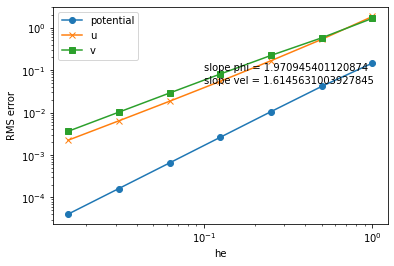

In [7]:
he_converge()